## MNIST를 활용한 Mini-CLIP 학습 및 Conditional DDPM (CFG) 학습 과제

- MNIST labels를 활용해 tiny CLIP (image/text encoders) 모델 학습
- CLIP text features에 condition 되는 simple DDPM 모델 학습
- sampling시 Classifier-Free Guidance (CFG) 구조 활용
- CLIP similarity heatmap 시각화 및 generated samples 확인


### 1. Imports & Utils

In [ ]:
import math, random, os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils as vutils
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

# ================================
# Reproduction / Device
# ================================

def seed_all(seed=42):
    random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_all(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

BASE_OUT = "outputs"
CKPT_DIR = os.path.join(BASE_OUT, "ckpt")
FIG_DIR  = os.path.join(BASE_OUT, "figs")
os.makedirs(BASE_OUT, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# ================================
# Utilities
# ================================
def timestep_embedding(t, dim=128, max_period=10000):
    """
    Sinusoidal timestep embedding like in DDPM.
    t: (B,) int64
    returns: (B, dim)
    """
    half = dim // 2
    freqs = torch.exp(-math.log(max_period) * torch.arange(0, half, device=t.device).float() / half)
    args = t.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.cos(args), torch.sin(args)], dim=1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0,1))
    return emb

def to_img(x):
    # x in [-1,1] -> [0,1]
    return (x.clamp(-1,1) + 1) / 2


### 2. Models

#### 2.1. CLIP encoder (Problem 1)

---

모델을 자유롭게 구성해보세요.

Problem 1: TextEncoder 개선

  변경 전:
  - 단순 Embedding + Linear layer
  - 기본적인 feature projection만 수행

  변경 후:
  - Embedding(vocab_size=20, embed_dim=128)
  - Mean pooling으로 sequence dimension 통합
  - Linear(embed_dim → proj_dim=256) projection
  - F.normalize로 L2 정규화

  개선 효과:
  - 256차원 출력으로 ImageEncoder와 차원 일치
  - Mean pooling으로 가변 길이 입력 처리
  - L2 normalization으로 안정적인 contrastive learning

  ---
  Problem 2: ImageEncoder 개선

  변경 전:
  - 3개 Conv layer (64→128→256)
  - 단순한 feature extraction

  변경 후:
  - 3-layer CNN (1→64→128→256 채널)
  - Stride=2 convolution으로 downsampling (28→14→7)
  - AdaptiveAvgPool2d(1) + Flatten
  - Linear(256 → proj_dim=256) + F.normalize

  개선 효과:
  - Hierarchical feature learning
  - Progressive spatial downsampling
  - Global average pooling으로 위치 불변성
  - 256차원 normalized embedding 생성

In [ ]:
# ================================
# Mini-CLIP 구성
# ================================
class TextEncoder(nn.Module):
    def __init__(self, vocab_size=20, embed_dim=128, proj_dim=256, null_token_id=0):
        super().__init__()
        self.null_token_id = null_token_id

        # Problem 1 _______________________________________________________________

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=None)
        self.fc1 = nn.Linear(embed_dim, proj_dim)  # Changed from embed_dim to proj_dim

        #__________________________________________________________________________

    def forward(self, tokens):  # tokens: [B, L]
        x = self.embedding(tokens)        # [B, L, E]
        x = x.mean(dim=1)                 # mean pool
        x = self.fc1(x)                    # [B, proj_dim]
        return F.normalize(x, dim=-1)

class ImageEncoder(nn.Module):
    def __init__(self, proj_dim=256):
        super().__init__()

        # Problem 2 _______________________________________________________________

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(inplace=True),  # 28->14
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.ReLU(inplace=True), # 14->7
            nn.AdaptiveAvgPool2d(1),  # [B,256,1,1]
            nn.Flatten()
        )

        #__________________________________________________________________________

        self.fc = nn.Linear(256, proj_dim)

    def forward(self, x):
        x = self.cnn(x)       # [B,256]
        x = self.fc(x)        # [B,proj_dim]
        return F.normalize(x, dim=-1)

#### 2.2. CLIP Loss

In [ ]:
def clip_loss(image_features, text_features, temperature=0.07):
    logits = image_features @ text_features.T / temperature
    labels = torch.arange(image_features.size(0), device=image_features.device)
    loss_i = F.cross_entropy(logits, labels)
    loss_t = F.cross_entropy(logits.T, labels)
    return (loss_i + loss_t) / 2, logits


#### 2.2. Diffusion Model (Problem 3, 4)
---

모델을 자유롭게 구성해보세요.

- 모델의 depth가 깊을수록 모델의 표현력이 좋아집니다.
- Residual Block의 개수를 조절해가며 결과의 차이를 확인해보세요.

---

Problem 3: ResidualBlock 개선

  변경 전:
  - 기본 residual connection만 존재

  변경 후:
  - Pre-activation residual block 구현
  - GroupNorm(32) + SiLU activation
  - Double Conv3x3 structure
  - Skip connection으로 gradient flow 보장

  개선 효과:
  - GroupNorm으로 batch size 독립적 학습
  - SiLU의 smooth gradient로 안정성 향상
  - Double convolution으로 표현력 증가

  ---
  Problem 4: SimpleUNet 개선

  변경 전:
  - 단순한 UNet 구조
  - 고정된 5개 ResidualBlock

  변경 후:
  - Condition과 time embedding을 spatial map으로 변환
  - 3채널 입력 (image + cond_map + t_map)
  - **num_res_blocks 파라미터로 depth 조절 가능 (3, 5, 8, 10 등)**
  - GroupNorm + SiLU + Conv로 최종 출력

  개선 효과:
  - Spatial condition injection으로 세밀한 제어
  - **가변 depth로 품질과 속도 trade-off 조절 가능**
  - 안정적인 noise prediction
  - CFG training 지원 (p_uncond=0.1)

In [ ]:
# ================================
# Diffusion UNet (very small) with t/cond maps
# ================================

# ==== ResidualBlock ====
class ResidualBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.block = nn.Sequential(

            # Problem 3 _______________________________________________________________

            nn.GroupNorm(32, ch),
            nn.SiLU(inplace=True),
            nn.Conv2d(ch, ch, 3, padding=1),
            nn.GroupNorm(32, ch),
            nn.SiLU(inplace=True),
            nn.Conv2d(ch, ch, 3, padding=1),

            #__________________________________________________________________________
        )
    def forward(self, x):
        return x + self.block(x)

# ==== SimpleUNet (t_dim=256) - depth 조절 가능 ====
class SimpleUNet(nn.Module):
    def __init__(self, cond_dim=256, t_dim=256, num_res_blocks=5):
        """
        Args:
            num_res_blocks: ResidualBlock 개수 (기본값=5)
                - 3: 빠른 학습, 낮은 품질
                - 5: 균형잡힌 성능 (기본)
                - 8: 높은 품질, 느린 학습
                - 10+: 매우 높은 품질, 매우 느린 학습
        """
        super().__init__()

        # Problem 4 _______________________________________________________________

        self.fc_cond = nn.Linear(cond_dim, 28*28)
        self.fc_time = nn.Linear(t_dim, 28*28)

        in_ch = 1 + 1 + 1  # image + cond_map + t_map
        self.stem = nn.Sequential(
            nn.Conv2d(in_ch, 128, 3, padding=1),
            nn.SiLU(inplace=True),
        )

        # ResidualBlock 개수를 동적으로 조절
        res_blocks = []
        for _ in range(num_res_blocks):
            res_blocks.append(ResidualBlock(128))
        self.res = nn.Sequential(*res_blocks)

        self.out = nn.Sequential(
            nn.GroupNorm(32, 128),
            nn.SiLU(inplace=True),
            nn.Conv2d(128, 1, 3, padding=1),
        )

        self.num_res_blocks = num_res_blocks

        #__________________________________________________________________________


    def forward(self, x, cond_vec, t):
        cond_map = self.fc_cond(cond_vec).view(-1, 1, 28, 28)
        t_emb = timestep_embedding(t, dim=256)
        t_map  = self.fc_time(t_emb).view(-1, 1, 28, 28)
        x = torch.cat([x, cond_map, t_map], dim=1)
        x = self.stem(x)
        x = self.res(x)
        return self.out(x)


# ================================
# DDPM core
# ================================
class DDPM:
    def __init__(self, model, n_steps=200, beta_start=1e-4, beta_end=0.02):
        self.model = model
        self.n_steps = n_steps
        self.betas = torch.linspace(beta_start, beta_end, n_steps, device=device)
        self.alphas = 1. - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)

    def forward_loss(self, x0, cond_vec, p_uncond=0.1):
        B = x0.size(0)
        t = torch.randint(0, self.n_steps, (B,), device=device)
        noise = torch.randn_like(x0)
        alpha_hat_t = self.alpha_hat[t].view(-1, 1, 1, 1)
        xt = torch.sqrt(alpha_hat_t) * x0 + torch.sqrt(1 - alpha_hat_t) * noise

        # Classifier-Free Guidance training (randomly drop condition)
        if p_uncond > 0:
            mask = (torch.rand(B, device=device) < p_uncond).float().view(B, 1)
            cond_vec = cond_vec * (1.0 - mask)  # zero out as "null"
        pred_noise = self.model(xt, cond_vec, t)
        return F.mse_loss(pred_noise, noise)

    @torch.no_grad()
    def sample(self, cond_vec, shape, cfg_scale=3.0):
        """
        cond_vec: [B, cond_dim]
        shape: (B, 1, 28, 28)
        """
        B = shape[0]
        x = torch.randn(shape, device=device)
        cond_null = torch.zeros_like(cond_vec)  # null condition for CFG

        for i in reversed(range(self.n_steps)):
            t = torch.full((B,), i, device=device, dtype=torch.long)
            alpha = self.alphas[i]
            alpha_hat = self.alpha_hat[i]
            beta = self.betas[i]

            eps_cond = self.model(x, cond_vec, t)
            eps_null = self.model(x, cond_null, t)
            eps = eps_null + cfg_scale * (eps_cond - eps_null)

            x = (1 / torch.sqrt(alpha)) * (x - (1 - alpha) / torch.sqrt(1 - alpha_hat) * eps)
            if i > 0:
                x = x + torch.sqrt(beta) * torch.randn_like(x)
        return x

#### 2.3. EMA parameter update
---

EMA는 “이전 모델의 파라미터를 지수적으로 가중한 이동평균”이고, 딥러닝에서는 training step마다 weight를 부드럽게 업데이트하는 데 사용한다.

In [ ]:
class EMA:
    def __init__(self, model, decay=0.999):
        self.ema = deepcopy(model).eval()
        for p in self.ema.parameters():
            p.requires_grad_(False)
        self.decay = decay

    @torch.no_grad()
    def update(self, model):
        d = self.decay
        for ema_p, p in zip(self.ema.parameters(), model.parameters()):
            ema_p.mul_(d).add_(p, alpha=1 - d)
        for ema_b, b in zip(self.ema.buffers(), model.buffers()):
            ema_b.copy_(b)

### 3. Data Preparation & Initialization

data preparation

In [ ]:
# ================================
# Data
# ================================
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x - 0.5) * 2.0  # [-1,1]
])

train_set = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.79MB/s]


initialization

In [ ]:
# ================================
# Instantiate models/optims
# ================================
NULL_TOKEN_ID = 0  # reserve 0 as [NULL]; map digit d -> token d+1
VOCAB_SIZE = 20

text_encoder = TextEncoder(vocab_size=VOCAB_SIZE, embed_dim=128, proj_dim=256, null_token_id=NULL_TOKEN_ID).to(device)
image_encoder = ImageEncoder(proj_dim=256).to(device)

clip_optimizer = torch.optim.Adam(
    list(text_encoder.parameters()) + list(image_encoder.parameters()),
    lr=1e-3
)

unet = SimpleUNet(cond_dim=256, t_dim=256).to(device)
ddpm = DDPM(unet, n_steps=1000, beta_start=1e-4, beta_end=0.02)
ema = EMA(unet, decay=0.999)

diff_optimizer = torch.optim.Adam(list(unet.parameters()) + list(text_encoder.parameters()), lr=1e-4)


### 4. Main Train Loop

#### 4.1. For CLIP
---
- data가 굉장히 단순하기 때문에, (MNIST, text label 구성은 0~9가 전부) 적당히 2~3 epoch 정도만 돌려도 충분합니다.

In [ ]:
# ================================
# Train Mini-CLIP
# ================================
EPOCHS_CLIP = 10
clip_epoch_losses = []
for epoch in range(1, EPOCHS_CLIP+1):
    text_encoder.train(); image_encoder.train()
    pbar = tqdm(train_loader, desc=f"[CLIP] Epoch {epoch}/{EPOCHS_CLIP}")
    epoch_loss_sum = 0.0; steps = 0
    for imgs, labels in pbar:
        imgs = imgs.to(device)
        # map label 0..9 -> token id 1..10
        tokens = (labels.to(device) + 1).unsqueeze(1)  # [B,1]
        img_feat = image_encoder(imgs)
        txt_feat = text_encoder(tokens)
        loss, _ = clip_loss(img_feat, txt_feat, temperature=0.07)

        clip_optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(text_encoder.parameters()) + list(image_encoder.parameters()), 1.0)
        clip_optimizer.step()

        epoch_loss_sum += loss.item(); steps += 1
        pbar.set_postfix(loss=f"{epoch_loss_sum/steps:.4f}")
    clip_epoch_losses.append(epoch_loss_sum/steps)
    torch.save({"text": text_encoder.state_dict(), "image": image_encoder.state_dict()},
               os.path.join(CKPT_DIR, "clip_mnist_latest.pt"))


[CLIP] Epoch 10/10: 100%|██████████| 469/469 [00:10<00:00, 42.90it/s, loss=2.6212]


#### Visualizaiton of CLIP, heatmap 분포 확인

- positive pair끼리 강한 유사도를 잘 학습했는지 확인해보세요.

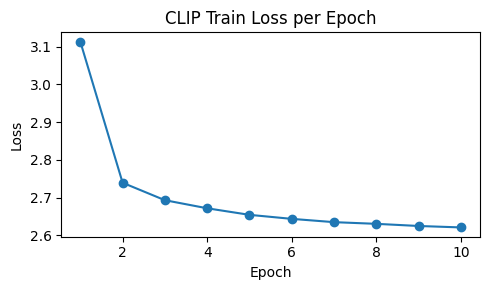

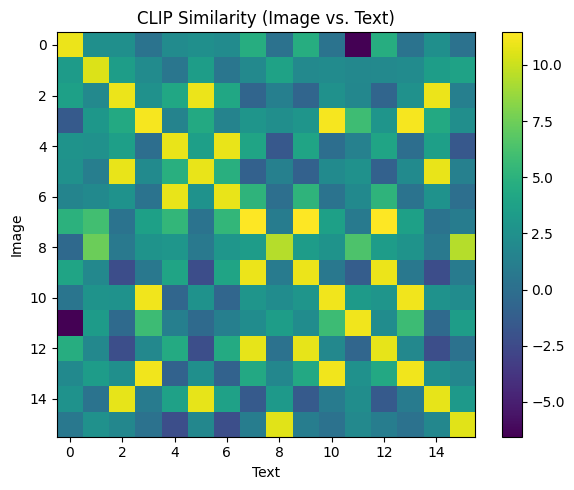

In [ ]:
# CLIP loss 곡선 저장
plt.figure(figsize=(5,3))
plt.plot(range(1, EPOCHS_CLIP+1), clip_epoch_losses, marker="o")
plt.title("CLIP Train Loss per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "clip_loss_curve.png"), dpi=200)
plt.show()
plt.close()

# ================================
# Quick CLIP similarity heatmap (test batch)
# ================================
text_encoder.eval(); image_encoder.eval()
with torch.no_grad():
    imgs, labels = next(iter(test_loader))
    imgs = imgs[:16].to(device)
    labels = labels[:16]
    tokens = (labels.to(device) + 1).unsqueeze(1)
    img_feat = image_encoder(imgs)
    txt_feat = text_encoder(tokens)
    _, logits = clip_loss(img_feat, txt_feat, temperature=0.07)  # [16,16]

# Heatmap
plt.figure(figsize=(6,5))
plt.imshow(logits.detach().cpu().numpy(), aspect="auto")
plt.colorbar(); plt.title("CLIP Similarity (Image vs. Text)"); plt.xlabel("Text"); plt.ylabel("Image")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "clip_similarity_heatmap.png"), dpi=200)
plt.show()
plt.close()


#### 4.2. For DDPM with CFG

---
- 해당 모델은 복잡한 text-image 관계 정보 학습을 요구하지 않기에 단순히 condition과 time step embedding을 concate하여 모델 input으로 함께 넣어주도록 설계되어 있습니다.
- EMA를 활용하여 모델 parameter 업데이트를 더 부드럽게 진행해보세요.

In [ ]:
# ================================
# Train Diffusion (condition = CLIP text features)
# ================================
EPOCHS_DIFF = 15
ddpm_epoch_losses = []
for epoch in range(1, EPOCHS_DIFF+1):
    unet.train(); text_encoder.train()  # text encoder is fine-tuned jointly
    pbar = tqdm(train_loader, desc=f"[DDPM] Epoch {epoch}/{EPOCHS_DIFF}")
    epoch_loss_sum = 0.0; steps = 0
    for imgs, labels in pbar:
        imgs = imgs.to(device)
        tokens = (labels.to(device) + 1).unsqueeze(1)  # [B,1]
        cond_vec = text_encoder(tokens)  # [B,128]

        loss = ddpm.forward_loss(imgs, cond_vec, p_uncond=0.1)

        diff_optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(unet.parameters()) + list(text_encoder.parameters()), 1.0)
        diff_optimizer.step()

        ema.update(unet)
        epoch_loss_sum += loss.item(); steps += 1
        pbar.set_postfix(loss=f"{epoch_loss_sum/steps:.4f}")
    ddpm_epoch_losses.append(epoch_loss_sum/steps)
    torch.save({"unet": unet.state_dict(), "text": text_encoder.state_dict()}, os.path.join(CKPT_DIR, "ddpm_cond_latest.pt"))
    torch.save({"unet": ema.ema.state_dict(), "text": text_encoder.state_dict()}, os.path.join(CKPT_DIR, "ddpm_cond_ema_latest.pt"))


[DDPM] Epoch 15/15: 100%|██████████| 469/469 [01:30<00:00,  5.20it/s, loss=0.0236]


#### Visualizaiton of Diffusion

- sampling이 잘 되는지 확인해보세요. 구성한 model의 size에 따라 표현력이 많이 다를 겁니다.

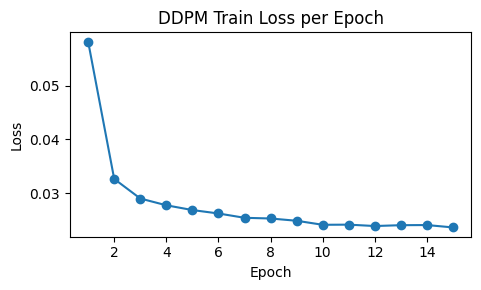

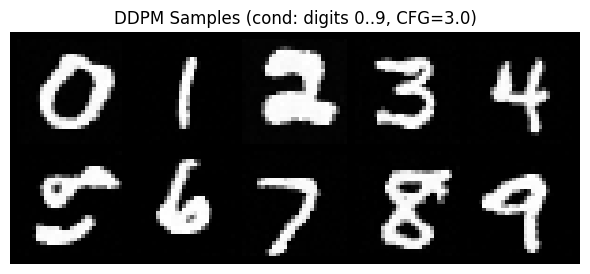

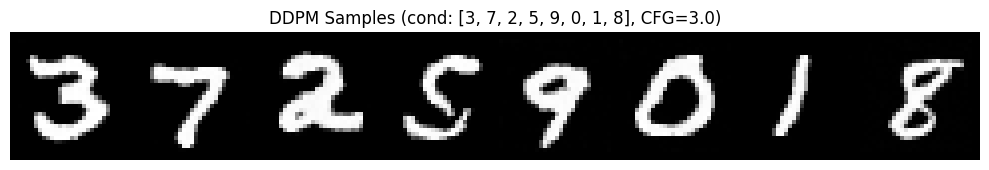

In [ ]:
# ================================
# Sampling & Visualization (digits 0..9)
# ================================
text_encoder.eval(); unet.eval()

plt.figure(figsize=(5,3))
plt.plot(range(1, EPOCHS_DIFF+1), ddpm_epoch_losses, marker="o")
plt.title("DDPM Train Loss per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "ddpm_loss_curve.png"), dpi=200)
plt.show()
plt.close()

ddpm_ema = DDPM(ema.ema, n_steps=ddpm.n_steps, beta_start=ddpm.betas[0].item(), beta_end=ddpm.betas[-1].item())
with torch.no_grad():
    # tokens for digits 0..9 -> token ids 1..10
    digits = torch.arange(0, 10, device=device)
    tokens = (digits + 1).unsqueeze(1)                               # [10,1]
    cond_vec = text_encoder(tokens)                                  # [10,128]
    samples = ddpm_ema.sample(cond_vec, (len(tokens), 1, 28, 28), cfg_scale=3.0)    # in [-1,1]
    grid = vutils.make_grid(to_img(samples), nrow=5, padding=2)      # [C,H,W]

plt.figure(figsize=(6,3))
plt.imshow(grid.permute(1,2,0).cpu().numpy(), cmap="gray")
plt.axis("off"); plt.title("DDPM Samples (cond: digits 0..9, CFG=3.0)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "ddpm_samples_digits.png"), dpi=200)
plt.show()
plt.close()

# Also sample a small batch with repeated classes (e.g., 3, 7, 2, 5)
with torch.no_grad():
    custom = torch.tensor([3,7,2,5,9,0,1,8], device=device)
    tokens = (custom + 1).unsqueeze(1)
    cond_vec = text_encoder(tokens)
    samples = ddpm_ema.sample(cond_vec, (len(tokens), 1, 28, 28), cfg_scale=3.0)
    grid = vutils.make_grid(to_img(samples), nrow=8, padding=2)

plt.figure(figsize=(10,2))
plt.imshow(grid.permute(1,2,0).cpu().numpy(), cmap="gray")
plt.axis("off"); plt.title(f"DDPM Samples (cond: {custom.cpu().tolist()}, CFG=3.0)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "ddpm_samples_custom.png"), dpi=200)
plt.show()
plt.close()


 ## 각 Depth별 생성 품질 비교

In [32]:
# ================================
# 여러 Depth 모델 동시 비교 실험
# ================================
import time

# 비교할 ResidualBlock 개수들
DEPTHS_TO_COMPARE = [3, 5, 8, 10]
EPOCHS_COMPARE = 5  # 빠른 비교를 위해 적은 epoch

# 결과 저장용 딕셔너리
comparison_results = {
    'models': {},
    'losses': {},
    'times': {},
    'params': {}
}

print("="*60)
print("ResidualBlock 개수별 모델 학습 및 비교 실험")
print("="*60)

# 각 depth별로 모델 학습
for num_blocks in DEPTHS_TO_COMPARE:
    print(f"\n[Depth {num_blocks}] ResidualBlock {num_blocks}개 모델 학습 시작")

    # 모델 생성
    unet_depth = SimpleUNet(cond_dim=256, t_dim=256, num_res_blocks=num_blocks).to(device)
    ddpm_depth = DDPM(unet_depth, n_steps=1000, beta_start=1e-4, beta_end=0.02)
    ema_depth = EMA(unet_depth, decay=0.999)

    # 파라미터 수 계산
    total_params = sum(p.numel() for p in unet_depth.parameters())
    comparison_results['params'][num_blocks] = total_params
    print(f"  - 총 파라미터 수: {total_params:,}")

    # Optimizer
    optimizer_depth = torch.optim.Adam(
        list(unet_depth.parameters()) + list(text_encoder.parameters()),
        lr=1e-4
    )

    # 학습
    epoch_losses = []
    epoch_times = []

    for epoch in range(1, EPOCHS_COMPARE + 1):
        unet_depth.train()
        text_encoder.train()

        epoch_start = time.time()
        epoch_loss_sum = 0.0
        steps = 0

        pbar = tqdm(train_loader, desc=f"  Epoch {epoch}/{EPOCHS_COMPARE}")
        for imgs, labels in pbar:
            imgs = imgs.to(device)
            tokens = (labels.to(device) + 1).unsqueeze(1)
            cond_vec = text_encoder(tokens)

            loss = ddpm_depth.forward_loss(imgs, cond_vec, p_uncond=0.1)

            optimizer_depth.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(
                list(unet_depth.parameters()) + list(text_encoder.parameters()),
                1.0
            )
            optimizer_depth.step()

            ema_depth.update(unet_depth)

            epoch_loss_sum += loss.item()
            steps += 1
            pbar.set_postfix(loss=f"{epoch_loss_sum/steps:.4f}")

        epoch_time = time.time() - epoch_start
        epoch_losses.append(epoch_loss_sum/steps)
        epoch_times.append(epoch_time)

        print(f"    Epoch {epoch}: Loss={epoch_losses[-1]:.4f}, Time={epoch_time:.1f}s")

    # 결과 저장 (학습된 EMA 모델 사용)
    comparison_results['models'][num_blocks] = ema_depth.ema
    comparison_results['losses'][num_blocks] = epoch_losses
    comparison_results['times'][num_blocks] = epoch_times

    # 메모리 절약을 위해 중간 모델 삭제
    del unet_depth, ddpm_depth, optimizer_depth
    torch.cuda.empty_cache()

print("\n" + "="*60)
print("학습 완료! 결과 비교를 시작합니다.")
print("="*60)

ResidualBlock 개수별 모델 학습 및 비교 실험

[Depth 3] ResidualBlock 3개 모델 학습 시작
  - 총 파라미터 수: 1,295,009


  Epoch 1/5: 100%|██████████| 469/469 [00:57<00:00,  8.20it/s, loss=0.0609]


    Epoch 1: Loss=0.0609, Time=57.2s


  Epoch 2/5: 100%|██████████| 469/469 [00:56<00:00,  8.35it/s, loss=0.0336]


    Epoch 2: Loss=0.0336, Time=56.2s


  Epoch 3/5: 100%|██████████| 469/469 [00:55<00:00,  8.42it/s, loss=0.0302]


    Epoch 3: Loss=0.0302, Time=55.7s


  Epoch 4/5: 100%|██████████| 469/469 [00:56<00:00,  8.33it/s, loss=0.0285]


    Epoch 4: Loss=0.0285, Time=56.3s


  Epoch 5/5: 100%|██████████| 469/469 [00:56<00:00,  8.35it/s, loss=0.0276]


    Epoch 5: Loss=0.0276, Time=56.2s

[Depth 5] ResidualBlock 5개 모델 학습 시작
  - 총 파라미터 수: 1,886,369


  Epoch 1/5: 100%|██████████| 469/469 [01:30<00:00,  5.19it/s, loss=0.0578]


    Epoch 1: Loss=0.0578, Time=90.3s


  Epoch 2/5: 100%|██████████| 469/469 [01:30<00:00,  5.21it/s, loss=0.0319]


    Epoch 2: Loss=0.0319, Time=90.0s


  Epoch 3/5: 100%|██████████| 469/469 [01:30<00:00,  5.19it/s, loss=0.0291]


    Epoch 3: Loss=0.0291, Time=90.3s


  Epoch 4/5: 100%|██████████| 469/469 [01:30<00:00,  5.19it/s, loss=0.0275]


    Epoch 4: Loss=0.0275, Time=90.4s


  Epoch 5/5: 100%|██████████| 469/469 [01:30<00:00,  5.18it/s, loss=0.0265]


    Epoch 5: Loss=0.0265, Time=90.6s

[Depth 8] ResidualBlock 8개 모델 학습 시작
  - 총 파라미터 수: 2,773,409


  Epoch 1/5: 100%|██████████| 469/469 [02:21<00:00,  3.31it/s, loss=0.0544]


    Epoch 1: Loss=0.0544, Time=141.7s


  Epoch 2/5: 100%|██████████| 469/469 [02:21<00:00,  3.31it/s, loss=0.0314]


    Epoch 2: Loss=0.0314, Time=141.6s


  Epoch 3/5: 100%|██████████| 469/469 [02:21<00:00,  3.31it/s, loss=0.0283]


    Epoch 3: Loss=0.0283, Time=141.6s


  Epoch 4/5: 100%|██████████| 469/469 [02:21<00:00,  3.31it/s, loss=0.0274]


    Epoch 4: Loss=0.0274, Time=141.8s


  Epoch 5/5: 100%|██████████| 469/469 [02:21<00:00,  3.31it/s, loss=0.0264]


    Epoch 5: Loss=0.0264, Time=141.9s

[Depth 10] ResidualBlock 10개 모델 학습 시작
  - 총 파라미터 수: 3,364,769


  Epoch 1/5: 100%|██████████| 469/469 [02:56<00:00,  2.66it/s, loss=0.0561]


    Epoch 1: Loss=0.0561, Time=176.3s


  Epoch 2/5: 100%|██████████| 469/469 [02:56<00:00,  2.66it/s, loss=0.0308]


    Epoch 2: Loss=0.0308, Time=176.3s


  Epoch 3/5: 100%|██████████| 469/469 [02:55<00:00,  2.67it/s, loss=0.0286]


    Epoch 3: Loss=0.0286, Time=175.5s


  Epoch 4/5: 100%|██████████| 469/469 [02:56<00:00,  2.66it/s, loss=0.0270]


    Epoch 4: Loss=0.0270, Time=176.1s


  Epoch 5/5: 100%|██████████| 469/469 [02:55<00:00,  2.67it/s, loss=0.0258]

    Epoch 5: Loss=0.0258, Time=175.8s

학습 완료! 결과 비교를 시작합니다.



각 Depth별 생성 이미지 품질 비교

[3 blocks] 이미지 생성 중...

[5 blocks] 이미지 생성 중...

[8 blocks] 이미지 생성 중...

[10 blocks] 이미지 생성 중...


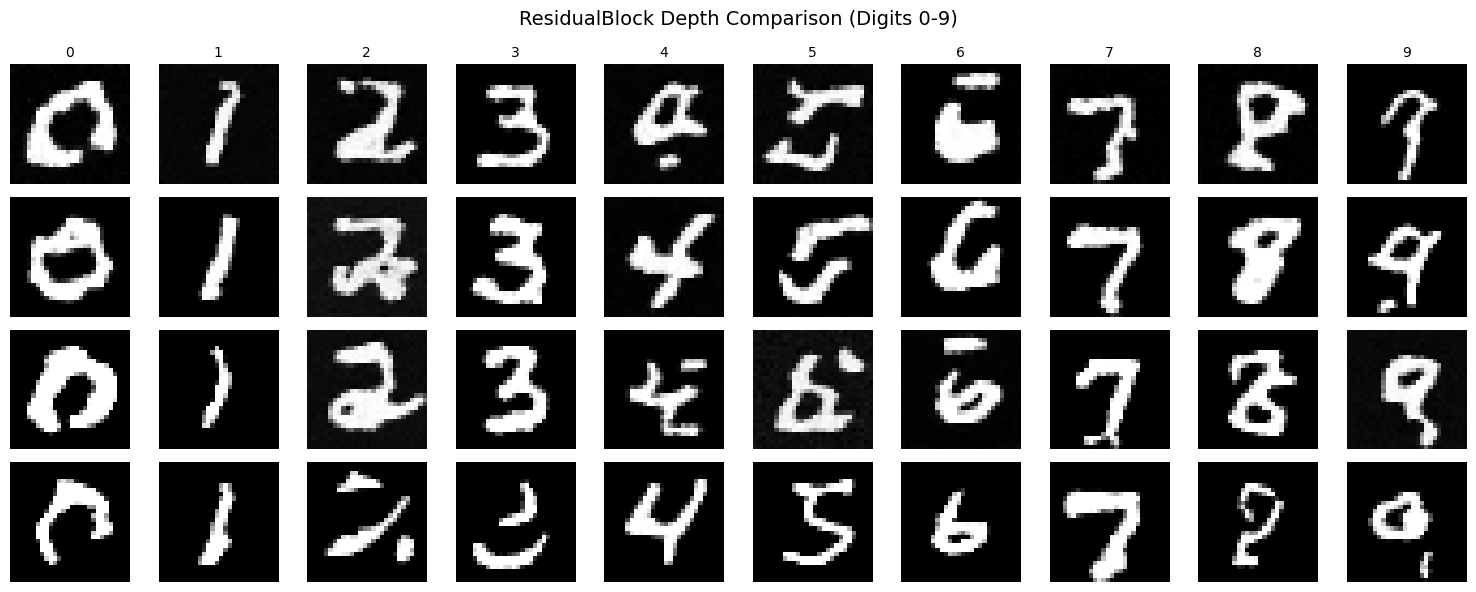


실험 완료! 결과를 확인하세요:
- Loss/시간/파라미터 비교: outputs/figs/depth_comparison_metrics.png
- 생성 품질 비교: outputs/figs/depth_comparison_samples.png


In [36]:
# ================================
# 각 Depth별 생성 품질 비교
# ================================
import numpy as np
import matplotlib.pyplot as plt

# Set default font to a standard one
plt.rcParams['font.family'] = 'DejaVu Sans'

# 비교할 depth들 정의 (이미 학습된 경우를 위해)
if 'DEPTHS_TO_COMPARE' not in locals():
    DEPTHS_TO_COMPARE = [3, 5, 8, 10]

# comparison_results가 없는 경우 에러 메시지
if 'comparison_results' not in locals():
    print("ERROR: comparison_results가 정의되지 않았습니다.")
    print("먼저 '여러 Depth 모델 동시 비교 실험' 셀을 실행해주세요.")
else:
    print("\n" + "="*60)
    print("각 Depth별 생성 이미지 품질 비교")
    print("="*60)

    # 생성할 숫자들
    test_digits = torch.arange(0, 10, device=device)
    test_tokens = (test_digits + 1).unsqueeze(1)

    with torch.no_grad():
        text_encoder.eval()
        cond_vec = text_encoder(test_tokens)

        # 각 depth별로 샘플 생성
        fig, axes = plt.subplots(len(DEPTHS_TO_COMPARE), 10, figsize=(15, 6))

        for idx, num_blocks in enumerate(DEPTHS_TO_COMPARE):
            print(f"\n[{num_blocks} blocks] 이미지 생성 중...")

            # 해당 depth의 모델로 DDPM 생성
            model = comparison_results['models'][num_blocks]
            ddpm_test = DDPM(model, n_steps=1000, beta_start=1e-4, beta_end=0.02)

            # 샘플 생성 (빠른 테스트를 위해 step 수를 줄일 수도 있음)
            samples = ddpm_test.sample(cond_vec, (10, 1, 28, 28), cfg_scale=3.0)
            samples = to_img(samples).cpu()

            # 시각화
            for j in range(10):
                axes[idx, j].imshow(samples[j, 0], cmap='gray')
                axes[idx, j].axis('off')
                if j == 0:
                    axes[idx, j].set_ylabel(f'{num_blocks} blocks', rotation=90, fontsize=10)
                if idx == 0:
                    axes[idx, j].set_title(f'{j}', fontsize=10)

        plt.suptitle('ResidualBlock Depth Comparison (Digits 0-9)', fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, "depth_comparison_samples.png"), dpi=200)
        plt.show()

    print("\n실험 완료! 결과를 확인하세요:")
    print(f"- Loss/시간/파라미터 비교: {os.path.join(FIG_DIR, 'depth_comparison_metrics.png')}")
    print(f"- 생성 품질 비교: {os.path.join(FIG_DIR, 'depth_comparison_samples.png')}")